# Differences In Dabest

## Introduction
Dabest was redesigned in the dev version (v 0.3.999) to accommodate the following functions:
    
    1. Delta-Delta
    2. Mini-meta

As a result, syntax for creating dabest objects and retrieval of data from dabest objects were changed. Since the changes were not documented thoroughly, the update resulted in inconsistencies on the user end, especially when the users are just trying to plot regular dabest plots.

In addition, the dev version adds the ability to process paired data via comparison to baseline or by sequential comparisons by passing the argument `paired = "sequential" or "baseline"`. This causes incompatibilities with current code, where `paired` can only receive a boolean True/False argument.

Finally, accessing the results of statistical tests via `.mean_diff.statistical_tests` is now broken, possibly as a result of implementing the new `paired` arguments.

#### Generating simulated data and plotting a regular dabest plot

In [48]:
import os
import numpy as np
import pandas as pd
import dabest
dabest.__version__
import matplotlib.pyplot as plt
# create a custom palette for coloring the plots
cPalette = ['gray', 'k', 'orangered']


def synthesizeData(setNumber, samplesize, genotypeEffect, lightEffect, realEffect):
    data = np.random.rand(samplesize*2, 1)
    dataDf = pd.DataFrame(data, columns = ['Metric'])
    dataDf['Light'] = 'Red Light On'
    dataDf['PairedID'] = dataDf.index
    dataDf.loc[0:samplesize-1, 'Light'] = 'Red Light Off'
    dataDf.loc[samplesize::, 'PairedID'] = dataDf.index[0:samplesize]
    parent1 = 'UAS' + str(setNumber)
    parent2 = 'Gal4' + str(setNumber)
    child = parent2 + '>' + parent1
    dataDf['Genotype'] = parent1
    dataDf.loc[1::3, 'Genotype'] = parent2
    dataDf.loc[2::3, 'Genotype'] = child
    dataDf['Status'] = 'Sibling'
    dataDf.loc[dataDf['Genotype'] == child, 'Status'] = 'Offspring'
    dataDf.loc[dataDf['Genotype'] == child, 'Metric'] = dataDf.loc[dataDf['Genotype'] == child, 'Metric'] + genotypeEffect
    dataDf.loc[dataDf['Light'] == 'Red Light On', 'Metric'] = dataDf.loc[dataDf['Light'] == 'Red Light On', 'Metric'] + lightEffect
    dataDf.loc[(dataDf['Genotype'] == child) & (dataDf['Light'] == 'Red Light On'), 'Metric'] = dataDf.loc[(dataDf['Genotype'] == child) & (dataDf['Light'] == 'Red Light On'), 'Metric'] + realEffect
    return dataDf

dataDf1 = synthesizeData(1, 60, -0.1, 0.05, 0.5)

C:\Users\maiyi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


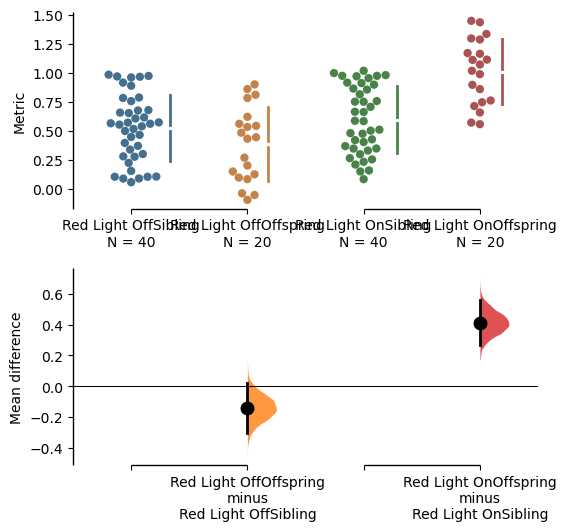

In [49]:
dataDf1['LightStatus'] = dataDf1['Light']+dataDf1['Status']
dataDf1['LightStatus'].unique()
contrast_unpaired = dabest.load(data = dataDf1, x ='LightStatus', y = 'Metric', idx = (('Red Light OffSibling', 'Red Light OffOffspring'),
       ('Red Light OnSibling', 'Red Light OnOffspring')))
f_unpaired = contrast_unpaired.mean_diff.plot()

In [50]:
contrast_unpaired.mean_diff.results

,control,test,control_N,test_N,effect_size,difference,ci,bca_low,bca_high,bca_interval_idx,...,permutations,pvalue_permutation,permutation_count,permutations_var,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Red Light OffSibling,Red Light OffOffspring,40,20,mean difference,-0.140313,95,-0.303120,0.019293,"(128, 4878)",...,"[-0.08677791475180774, -0.08465622359054836, -...",0.0938,5000,"[0.006116893370582743, 0.0074812722891417095, ...",0.104258,1.668362,0.088861,1.730487,0.083135,511.0
1,Red Light OnSibling,Red Light OnOffspring,40,20,mean difference,0.412709,95,0.266302,0.562394,"(130, 4880)",...,"[0.07038674934054112, -0.13284906495220283, -0...",0.0000,5000,"[0.009409946087692161, 0.008470857374211696, 0...",0.000004,-5.339787,0.000002,-5.283120,0.000022,129.0


## 1. Locating the statistical results in a dabest object (Delta-delta)

#### In the original Dabest:

Effects and results of other statistical comparisons are stored in the dabest object in the property `.results`. E.g. `.mean_diff.results`. In original design, each of the items in `.results` is a list of length n, where n is the total number of bootstraps performed in the plot. 

#### In the dev version:

The `.mean_diff.results.bootstraps` only contains two arrays, omitting the delta delta bootstraps

Instead, the delta delta bootstraps are now found via `.mean_diff.delta_delta.bootstraps_delta_delta`.

Same situation with selecting the CIs or the mean difference.

This marks a significant departure from the old use case and confused users, and needs to be documented or redesigned.

Ideally, for delta delta experiments, since there are typically two comparisons, each item in `.results` would have a length of 3, 2 for the 2 deltas, and 1 for the delta-delta. For example, you could use `.mean_diff.results.bootstraps` to find the bootstraps (resampled data points), and it would contain 3 arrays. The first two would be for the mean diff:

`.mean_diff.results.bootstraps[0]`   or   `.mean_diff.results.bootstraps[1]`

The third would be for the delta delta:

`.mean_diff.results.bootstraps[2]`

C:\Users\maiyi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


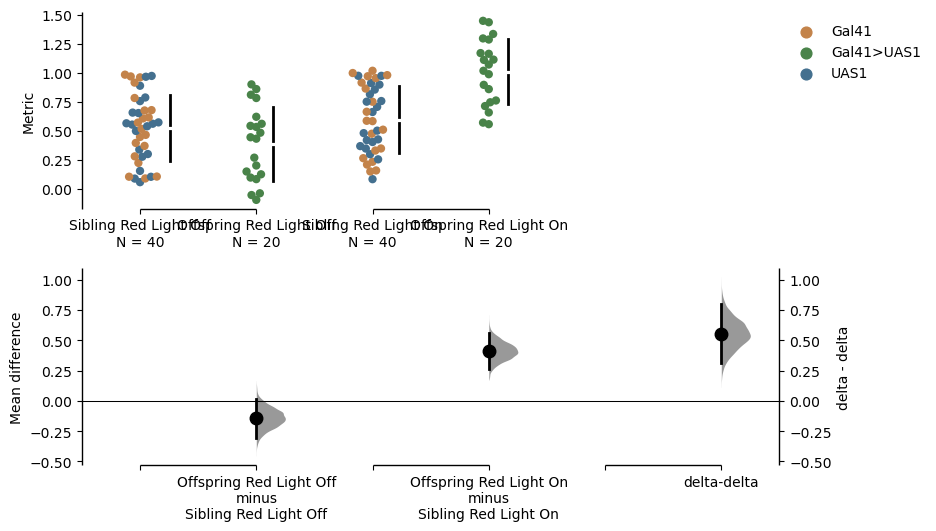

In [51]:
contrast_delta2 = dabest.load(data = dataDf1,
                       x=['Status', 'Genotype'], # the default for this test config is to group flies by genotype
                       y='Metric',
                        delta2 = True, 
                        experiment = 'Light'
                       )

f_delta2 = contrast_delta2.mean_diff.plot()

In [52]:
contrast_delta2.mean_diff.delta_delta

DABEST v0.3.9999
                
Good morning!
The current time is Mon Oct 24 11:27:13 2022.

The delta-delta between Red Light Off and Red Light On is 0.553 [95%CI 0.313, 0.804].
The p-value of the two-sided permutation t-test is 0.0, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis ofzero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

In [56]:
contrast_delta2.mean_diff.delta_delta.bootstraps_delta_delta

array([0.2717344 , 0.54897786, 0.48337985, ..., 0.5297525 , 0.49912449,
       0.49243061])

## 2. Mini-meta

Mini-meta suffers from largely the same problems as the delta-delta plots, i.e. difficulty accessing the weighted-delta results and attributes.

C:\Users\maiyi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


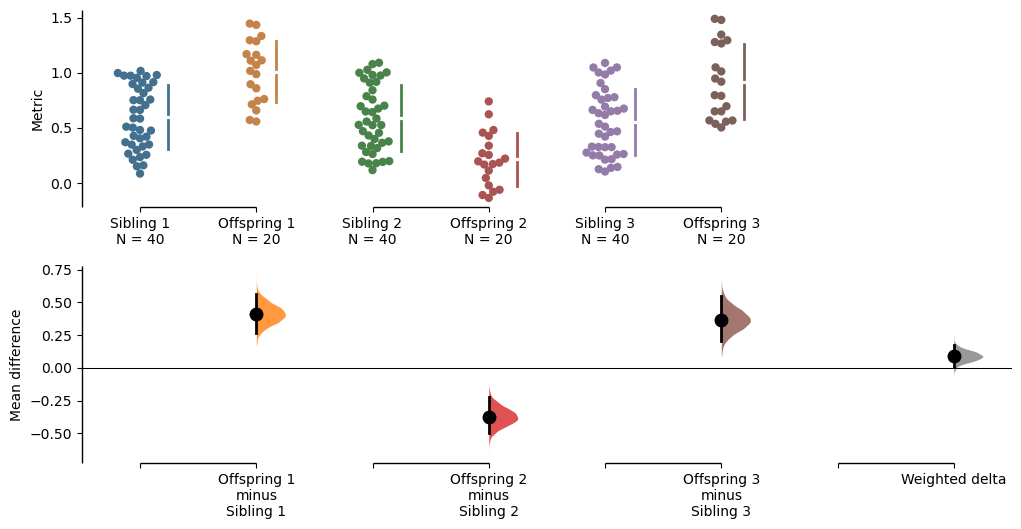

In [57]:
dataDf2 = synthesizeData(1, 60, -0.05, 0.1, -0.3)
dataDf3 = synthesizeData(1, 60, 0.00, 0.1, 0.4)

dataDf1_rename = dataDf1.replace({"Sibling" : "Sibling 1" , "Offspring" : "Offspring 1"})
dataDf2_rename = dataDf2.replace({"Sibling" : "Sibling 2" , "Offspring" : "Offspring 2"})
dataDf3_rename = dataDf3.replace({"Sibling" : "Sibling 3" , "Offspring" : "Offspring 3"})

data_forMiniMeta2 = pd.concat([dataDf1_rename, dataDf2_rename, dataDf3_rename])
data_forMiniMeta2 = data_forMiniMeta2.loc[(data_forMiniMeta2["Light"].str.contains("On"))]
data_forMiniMeta2

contrast_minimeta = dabest.load(data = data_forMiniMeta2,
                        idx = (('Sibling 1', 'Offspring 1'),
                             ('Sibling 2', 'Offspring 2'),
                              ('Sibling 3', 'Offspring 3')),
                        x = "Status",
                        y = "Metric",
                        mini_meta = True, 
                        id_col="PairedID"
                      )

f_minimeta = contrast_minimeta.mean_diff.plot()

#### Bootstrap attributes

Somewhat confusingly, the MiniMetaDelta object has two bootstrap attributes: '.mean_diff.mini_meta_delta.bootstraps' and '.mean_diff.mini_meta_delta.bootstraps_weighted_delta'; the former outputs only the bootstraps used for each experimental pair used in the mini-meta analysis, whereas the latter outputs only the bootstraps used for the MiniMetaDelta.

This is similar to the problem seen with delta-delta.

In [58]:
contrast_minimeta.mean_diff.mini_meta_delta.bootstraps

array([array([0.29720369, 0.42025048, 0.32688438, ..., 0.39841942, 0.38514193,
              0.35294674])                                                    ,
       array([-0.35256387, -0.35062128, -0.28568478, ..., -0.30607492,
              -0.36002965, -0.42777809])                              ,
       array([0.26419109, 0.38548529, 0.42445636, ..., 0.29211662, 0.30389348,
              0.38067019])                                                    ],
      dtype=object)

In [59]:
contrast_minimeta.mean_diff.mini_meta_delta.bootstraps_weighted_delta

array([0.03112771, 0.10572341, 0.10939276, ..., 0.09166022, 0.06875418,
       0.05070886])

#### Mean difference and statistical tests

The results of `.mean_diff` outputs the mean difference and confidence intervals for all three replicates as well as the delta-delta. However, `.mean_diff.results` only outputs the results for the original three replicates. 

In [60]:
contrast_minimeta.mean_diff

DABEST v0.3.9999
                
Good morning!
The current time is Mon Oct 24 11:27:50 2022.

The unpaired mean difference between Sibling 1 and Offspring 1 is 0.413 [95%CI 0.266, 0.562].
The p-value of the two-sided permutation t-test is 0.0, calculated for legacy purposes only. 

The unpaired mean difference between Sibling 2 and Offspring 2 is -0.373 [95%CI -0.502, -0.223].
The p-value of the two-sided permutation t-test is 0.0, calculated for legacy purposes only. 

The unpaired mean difference between Sibling 3 and Offspring 3 is 0.369 [95%CI 0.202, 0.549].
The p-value of the two-sided permutation t-test is 0.0, calculated for legacy purposes only. 

The weighted-average unpaired mean differences is 0.0899 [95%CI 0.01, 0.174].
The p-value of the two-sided permutation t-test is 0.0576, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect si

In [61]:
contrast_minimeta.mean_diff.results

,control,test,control_N,test_N,effect_size,difference,ci,bca_low,bca_high,bca_interval_idx,...,permutations,pvalue_permutation,permutation_count,permutations_var,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Sibling 1,Offspring 1,40,20,mean difference,0.412709,95,0.266302,0.562394,"(130, 4880)",...,"[0.07038674934054112, -0.13284906495220283, -0...",0.0,5000,"[0.009409946087692161, 0.008470857374211696, 0...",0.000004,-5.339787,0.000002,-5.283120,0.000022,129.0
1,Sibling 2,Offspring 2,40,20,mean difference,-0.373202,95,-0.501652,-0.222652,"(161, 4905)",...,"[0.03515229682317483, 0.07522215992929038, -0....",0.0,5000,"[0.00758231098072033, 0.009293377807656794, 0....",0.000005,5.178990,0.000010,4.841001,0.000036,664.0
2,Sibling 3,Offspring 3,40,20,mean difference,0.369100,95,0.202435,0.549175,"(144, 4892)",...,"[0.20432222327612914, 0.09051528850446955, 0.0...",0.0,5000,"[0.008567255122537277, 0.009882799015430335, 0...",0.000212,-4.141878,0.000064,-4.309334,0.000514,178.0


As a results of this, accessing individual attributes such as mean difference, CI, etc. have to be done manually by using`.mean_diff.mini_meta_delta.xx`. In addition, it is not currently possible to obtain the p-values of any statistical test other than permutation t-test for the weighted delta. The required attributes don't seem to exist. 

In [62]:
contrast_minimeta.mean_diff.mini_meta_delta.difference

0.08992953087561972

## 3. Paired syntax for dabest.load() method

To accomodate new paradigms such as delta-delta and mini-meta, the way input arguments are passed to dabest.load() is redesigned. 

#### dabest live:

`dabest.load(data, idx, x=None, y=None, *paired=False, id_col=None, ci=95, resamples=5000, random_seed=12345)`

*paired : boolean, default False.

The live dabest (including the tutorial) allows **true** or **false** for the argument `paired`
This throws an error in the dev version, "**True** assigned for `paired` is not valid."


#### dabest dev:

`dabest.load(data, idx=None, x=None, y=None, *paired=None, id_col=None, ci=95, resamples=5000, random_seed=12345, proportional=False, delta2=False, experiment=None,experiment_label=None, x1_level=None, mini_meta=False)`

*paired : string, default None

The dev version now uses **baseline**, **sequential**, or **None** but this is not documented in the method signature and therefore confused users. 

In [63]:
### This causes an error.

contrast_paired_broken = dabest.load(data = dataDf1, x ='LightStatus', y = 'Metric', idx = (('Red Light OffSibling', 'Red Light OffOffspring'),
       ('Red Light OnSibling', 'Red Light OnOffspring')), paired = True)
contrast_paired_broken.mean_diff

ValueError: True assigned for `paired` is not valid.

In [64]:
contrast_paired = dabest.load(data = dataDf1, x ='LightStatus', y = 'Metric', 
                        idx = (('Red Light OffSibling', 'Red Light OnSibling'),
       ('Red Light OffOffspring', 'Red Light OnOffspring')), 
                        paired = 'baseline', id_col = 'PairedID'
                       )

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,permutations,pvalue_permutation,permutation_count,permutations_var,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Red Light OffSibling,Red Light OnSibling,40,40,mean difference,baseline,0.069884,95,-0.056007,0.191479,...,5000,12345,"[-0.03508666997952781, -0.04294926541766286, 0...",0.2736,5000,"[0.004153349336517733, 0.00414548311870152, 0....",0.294445,332.0,0.280757,-1.09379
1,Red Light OffOffspring,Red Light OnOffspring,20,20,mean difference,baseline,0.622906,95,0.404573,0.817234,...,5000,12345,"[-0.0985620016351908, 0.1775556841617425, -0.0...",0.0000,5000,"[0.018895512780314164, 0.01832152454842445, 0....",0.000048,8.0,0.000015,-5.76565


C:\Users\maiyi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


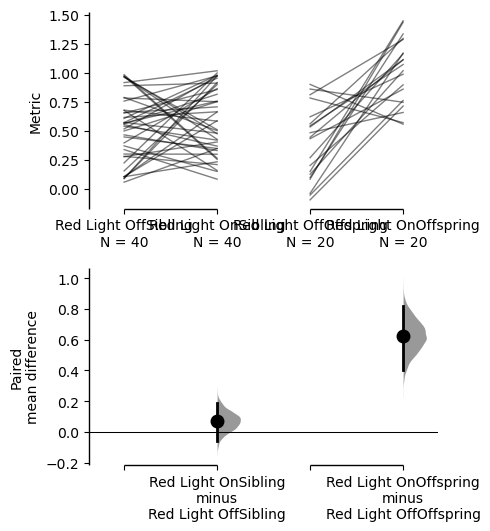

In [66]:
contrast_paired.mean_diff
f_paired = contrast_paired.mean_diff.plot()
contrast_paired.mean_diff.results

#### dabest.mean_diff.statistical_tests attribute is broken

`dabest.mean_diff.statistical_tests` outputs an error: "['is_paired'] not in index"

`dabest.mean_diff.statistical_tests` DOES actually work when data is paired, but not when it is unpaired. So it is likely this broke at some point due to the implementation of the new arguments for processing paired data.
While the results of statistical tests can be accessed via `.mean_diff.results`, running `.mean_diff` still instructs the user:

"To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`"

which does not function properly.



##### Example: paired data (`.mean_diff.statistical_tests` does work)

In [67]:
contrast_paired.mean_diff

DABEST v0.3.9999
                
Good morning!
The current time is Mon Oct 24 11:28:23 2022.

The paired mean difference for repeated measures against baseline 
between Red Light OffSibling and Red Light OnSibling is 0.0699 [95%CI -0.056, 0.191].
The p-value of the two-sided permutation t-test is 0.274, calculated for legacy purposes only. 

The paired mean difference for repeated measures against baseline 
between Red Light OffOffspring and Red Light OnOffspring is 0.623 [95%CI 0.405, 0.817].
The p-value of the two-sided permutation t-test is 0.0, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis ofzero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`

In [68]:
contrast_paired.mean_diff.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Red Light OffSibling,Red Light OnSibling,40,40,mean difference,baseline,0.069884,95,-0.056007,0.191479,0.2736,0.294445,332.0,0.280757,-1.09379
1,Red Light OffOffspring,Red Light OnOffspring,20,20,mean difference,baseline,0.622906,95,0.404573,0.817234,0.0000,0.000048,8.0,0.000015,-5.76565


##### Example: unpaired data (`.mean_diff.statistical_tests` does NOT work)

In [69]:
contrast_unpaired.mean_diff.results

,control,test,control_N,test_N,effect_size,difference,ci,bca_low,bca_high,bca_interval_idx,...,permutations,pvalue_permutation,permutation_count,permutations_var,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Red Light OffSibling,Red Light OffOffspring,40,20,mean difference,-0.140313,95,-0.303120,0.019293,"(128, 4878)",...,"[-0.08677791475180774, -0.08465622359054836, -...",0.0938,5000,"[0.006116893370582743, 0.0074812722891417095, ...",0.104258,1.668362,0.088861,1.730487,0.083135,511.0
1,Red Light OnSibling,Red Light OnOffspring,40,20,mean difference,0.412709,95,0.266302,0.562394,"(130, 4880)",...,"[0.07038674934054112, -0.13284906495220283, -0...",0.0000,5000,"[0.009409946087692161, 0.008470857374211696, 0...",0.000004,-5.339787,0.000002,-5.283120,0.000022,129.0


In [70]:
contrast_unpaired.mean_diff.statistical_tests

KeyError: "['is_paired'] not in index"